## Effect of Batch Normalisation on CNN Training Stability (MNIST)
### Machine Learning & Neural Networks – Individual Assignment


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize & reshape
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Training set:", x_train.shape)
print("Test set:", x_test.shape)


Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


## What is Batch Normalisation?
Batch Normalisation stabilises and accelerates training by normalising intermediate activations.

It reduces:
- internal covariate shift  
- exploding/vanishing gradients  
- sensitivity to weight initialisation  
- training instability  

We compare:
1. **A CNN WITHOUT BatchNorm**  
2. **A CNN WITH BatchNorm after each Conv layer**  

Everything else remains identical.


In [2]:
def build_cnn_no_bn():
    inputs = Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3,3), activation="relu")(inputs)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(64, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


## Model With Batch Normalisation
BatchNorm is added after each Conv layer, before ReLU.


In [3]:
def build_cnn_with_bn():
    inputs = Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3,3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(64, (3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


## Training the Two Models
We train both for 3 epochs and compare stability using:
- Training accuracy  
- Validation accuracy  
- Training loss  
- Validation loss  


In [4]:
model_no_bn = build_cnn_no_bn()
model_bn = build_cnn_with_bn()

history_no_bn = model_no_bn.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=1
)

history_bn = model_bn.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=1
)


Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9512 - loss: 0.1611 - val_accuracy: 0.9801 - val_loss: 0.0588
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9844 - loss: 0.0500 - val_accuracy: 0.9906 - val_loss: 0.0294
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9891 - loss: 0.0338 - val_accuracy: 0.9875 - val_loss: 0.0355
Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9729 - loss: 0.0967 - val_accuracy: 0.9817 - val_loss: 0.0568
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9901 - loss: 0.0337 - val_accuracy: 0.9843 - val_loss: 0.0499
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9923 - loss: 0.0248 - val_accuracy: 0.9894 - val_loss: 0.0353


## Validation Accuracy Comparison
We expect BatchNorm to:
- converge faster  
- be more stable  
- generalise better  


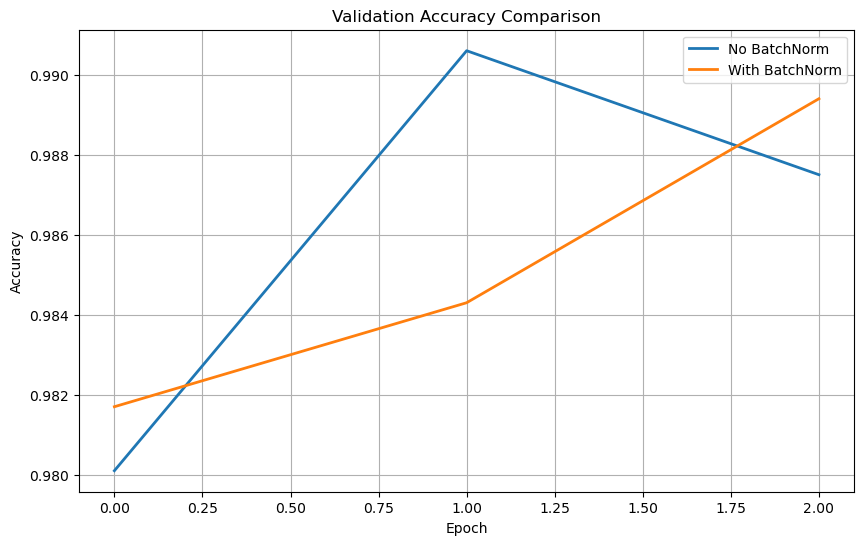

Saved: batchnorm_accuracy_comparison.png


In [5]:
plt.figure(figsize=(10,6))

plt.plot(history_no_bn.history["val_accuracy"], label="No BatchNorm", linewidth=2)
plt.plot(history_bn.history["val_accuracy"], label="With BatchNorm", linewidth=2)

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.savefig("batchnorm_accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: batchnorm_accuracy_comparison.png")


## Training Loss Comparison
BatchNorm typically produces smoother training curves and reduces instability.


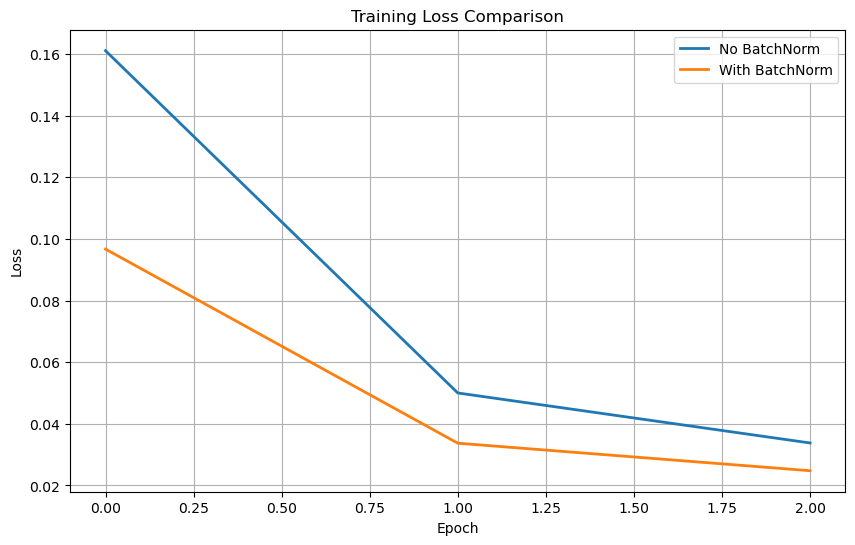

Saved: batchnorm_loss_comparison.png


In [6]:
plt.figure(figsize=(10,6))

plt.plot(history_no_bn.history["loss"], label="No BatchNorm", linewidth=2)
plt.plot(history_bn.history["loss"], label="With BatchNorm", linewidth=2)

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.savefig("batchnorm_loss_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: batchnorm_loss_comparison.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


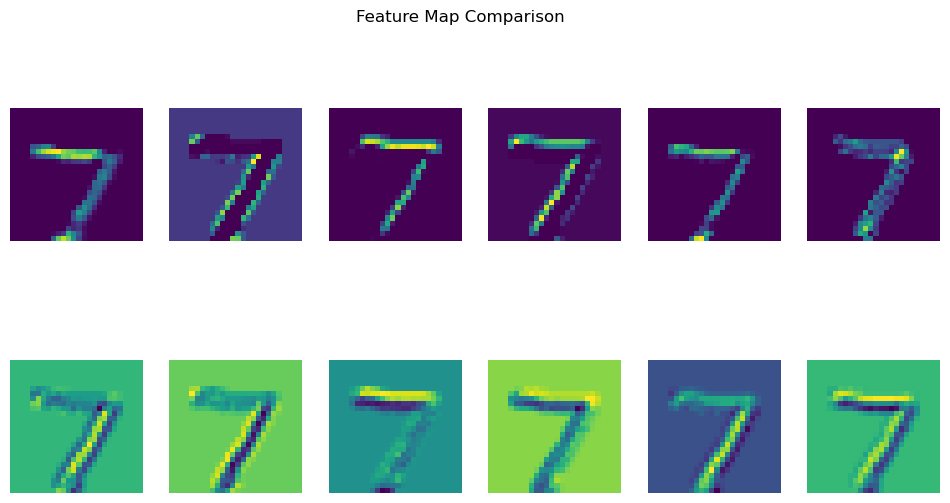

Saved: batchnorm_featuremaps.png


In [7]:
# Get input ready
test_img = np.expand_dims(x_test[0], axis=0)

# Build models
model_no_bn(x_train[:1])
model_bn(x_train[:1])

# Extract first conv outputs
layer_no_bn = model_no_bn.layers[1].output
layer_bn = model_bn.layers[1].output

act_no_bn = models.Model(model_no_bn.input, layer_no_bn)
act_bn = models.Model(model_bn.input, layer_bn)

fm_no_bn = act_no_bn.predict(test_img)[0]
fm_bn = act_bn.predict(test_img)[0]

# Plot comparison (first 6 maps)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(fm_no_bn[..., i], cmap="viridis")
    plt.axis("off")
    if i == 0:
        plt.ylabel("No BatchNorm", fontsize=14)

    plt.subplot(2,6,i+7)
    plt.imshow(fm_bn[..., i], cmap="viridis")
    plt.axis("off")
    if i == 0:
        plt.ylabel("With BatchNorm", fontsize=14)

plt.suptitle("Feature Map Comparison")
plt.savefig("batchnorm_featuremaps.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: batchnorm_featuremaps.png")
